In [9]:
import torch
from matplotlib import pyplot as plt
from matplotlib import rc
import numpy as np
import xarray as xr

rc("font", **{"family": "Times"})
rc("text", usetex=True)
plt.rcParams['figure.dpi'] = 150

!scp bp:samples.pt .

test = xr.open_dataset("test.nc").pr.values
samples = torch.load("samples.pt", map_location=torch.device('cpu')).numpy()
# samples = torch.load("cond_sample/long_video.pt", map_location=torch.device('cpu')).numpy()
# samples = torch.load("samples_sqrt.pt", map_location=torch.device('cpu')).numpy()[:1000]
# samples = torch.load("samples_no_sqrt.pt", map_location=torch.device('cpu')).numpy()
# samples = torch.load("test111.pt", map_location=torch.device('cpu')).numpy()

test_cells_sorted = torch.load("test_flattened_sorted.pt").numpy()
samples_cells_sorted = np.sort(samples.flatten())

test_frames = test.reshape(-1, 64 * 64)
test_frames_mean = np.mean(test_frames, axis=1)
test_frames_mean_sorted = np.sort(test_frames_mean)
samples_frames = samples.reshape(-1, 64 * 64)
samples_frames_mean = np.mean(samples_frames, axis=1)
samples_frames_mean_sorted = np.sort(samples_frames_mean)

test_videos = test.reshape(-1, 10 * 64 * 64)
test_videos_mean = np.mean(test_videos, axis=1)
test_videos_mean_sorted = np.sort(test_videos_mean)
samples_videos = samples.reshape(-1, 10 * 64 * 64)
samples_videos_mean = np.mean(samples_videos, axis=1)
samples_videos_mean_sorted = np.sort(samples_videos_mean)

print(samples.shape)

samples.pt                                    100%   25MB   3.3MB/s   00:07    
(160, 1, 10, 64, 64)


QQ Plot for Individual Cells:


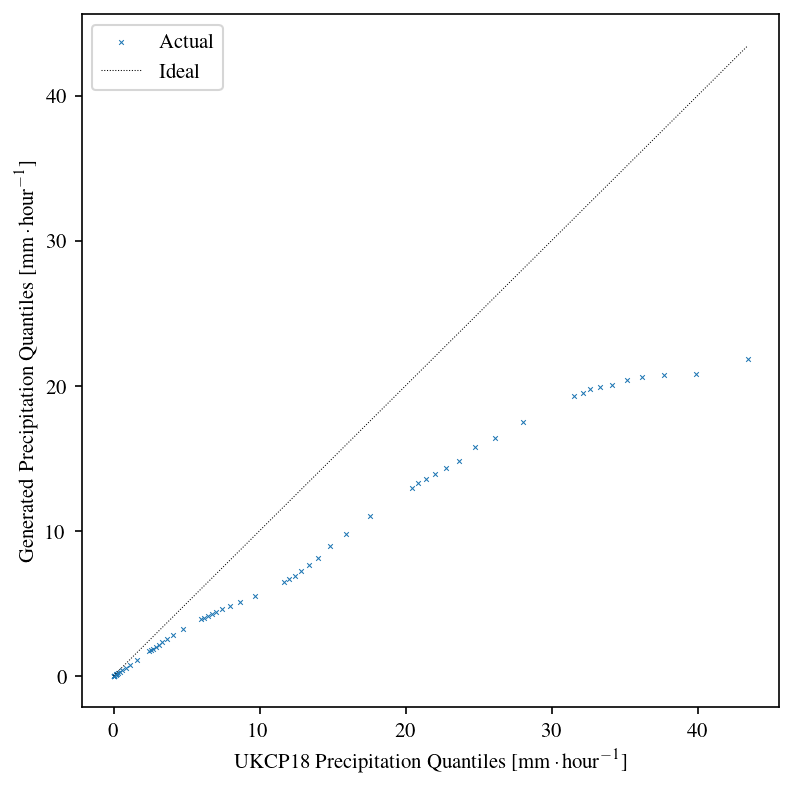

QQ Plot for Frame Averages:


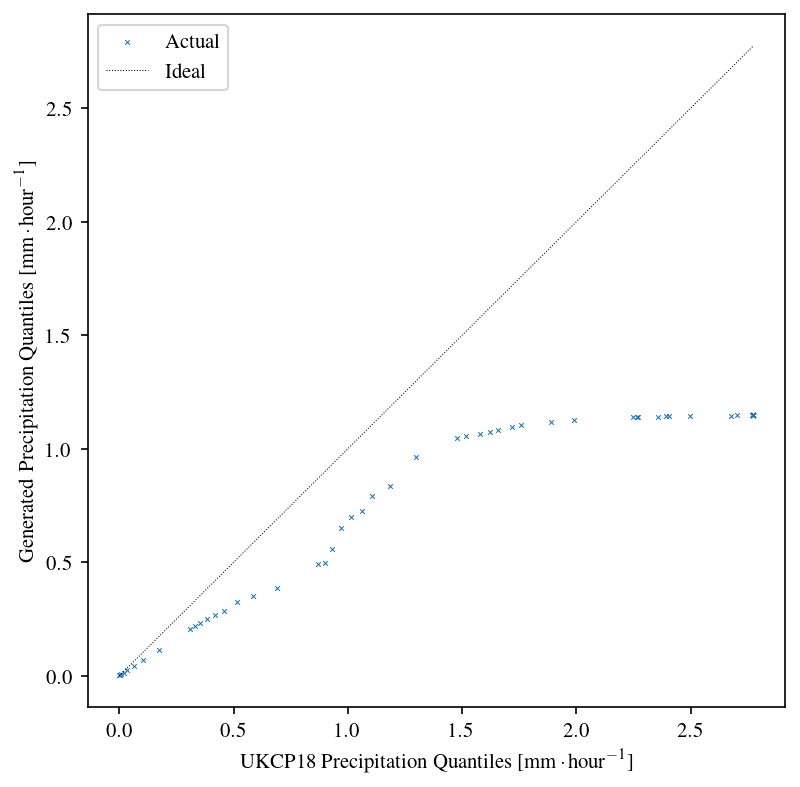

QQ Plot for Video Averages:


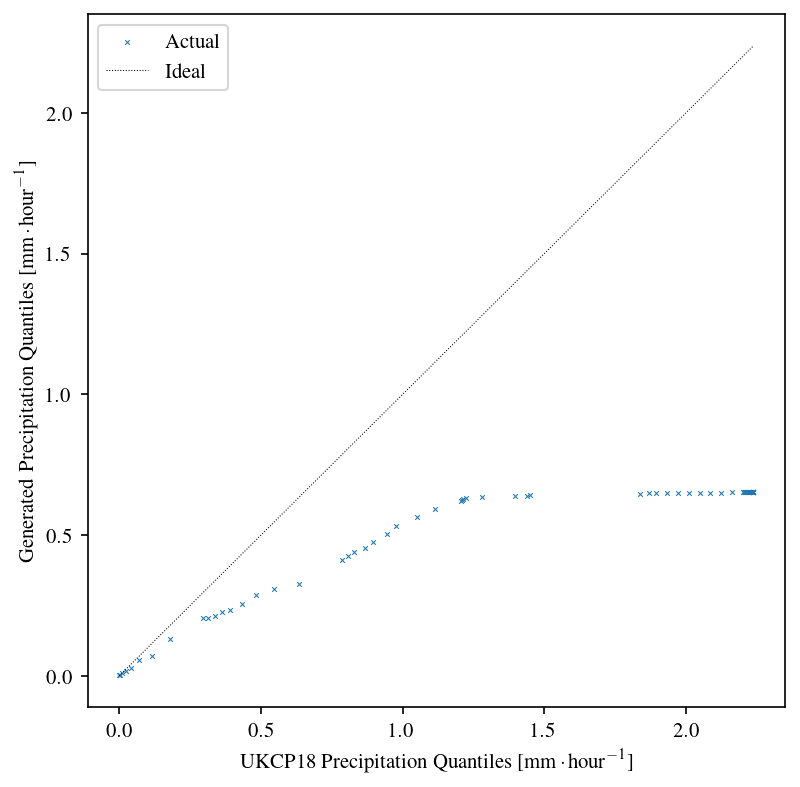

In [10]:
def get_quantiles(sorted_array, desired_quantiles):
    indices = (len(sorted_array) - 1) * desired_quantiles
    indices_floor = np.floor(indices).astype(int)
    indices_ceil = np.ceil(indices).astype(int)

    indices_fractional_part = indices - indices_floor

    quantiles_floor = sorted_array[indices_floor]
    quantiles_ceil = sorted_array[indices_ceil]

    quantiles = quantiles_floor + indices_fractional_part * (quantiles_ceil - quantiles_floor)

    return quantiles

def plot_qq(test_quantiles, samples_quantiles, log = False):
    plt.figure(figsize=(6, 6))
    plt.scatter(test_quantiles, samples_quantiles, marker = 'x', s = 5, linewidth = 0.5, label = "Actual")
    # plt.plot(test_quantiles, samples_quantiles, linewidth = 0.5, label = "Actual")
    plt.plot(test_quantiles, test_quantiles, linewidth = 0.5, linestyle=":", c = "black", label = "Ideal")
    plt.legend()

    plt.xscale('log' if log else 'linear')
    plt.yscale('log' if log else 'linear')
    
    plt.xlabel('UKCP18 Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')
    plt.ylabel('Generated Precipitation Quantiles [$\mathrm{mm}\cdot\mathrm{hour}^{-1}$]')

    plt.show()

desired_quantiles = np.concatenate([np.linspace((1 - 10 ** (i + 1)) + (10 ** i), (1-10**i), 9) for i in range(-1, -8, -1)])
# desired_quantiles = 1 - np.geomspace(1, 0.0000001, 1000)
# print(desired_quantiles)

test_cells_quantiles = get_quantiles(test_cells_sorted, desired_quantiles)
samples_cells_quantiles = get_quantiles(samples_cells_sorted, desired_quantiles)

test_frames_quantiles = get_quantiles(test_frames_mean_sorted, desired_quantiles)
samples_frames_quantiles = get_quantiles(samples_frames_mean_sorted, desired_quantiles)

test_videos_quantiles = get_quantiles(test_videos_mean_sorted, desired_quantiles)
samples_videos_quantiles = get_quantiles(samples_videos_mean_sorted, desired_quantiles)

print("QQ Plot for Individual Cells:")
plot_qq(test_cells_quantiles, samples_cells_quantiles)
print("QQ Plot for Frame Averages:")
plot_qq(test_frames_quantiles, samples_frames_quantiles)
print("QQ Plot for Video Averages:")
plot_qq(test_videos_quantiles, samples_videos_quantiles)